In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import datetime as dt
import folium
from folium.plugins import HeatMap
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

## 1. Exploratory Data Analysis

#### Import the data

In [3]:
df = pd.read_csv('robotex5.csv')

In [4]:
df.shape

(627210, 6)

In [5]:
df.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100


In [6]:
df.dtypes

start_time     object
start_lat     float64
start_lng     float64
end_lat       float64
end_lng       float64
ride_value    float64
dtype: object

In [7]:
# Parse start time
df['start_time'] = pd.to_datetime(df['start_time'])

In [8]:
df.dtypes

start_time    datetime64[ns]
start_lat            float64
start_lng            float64
end_lat              float64
end_lng              float64
ride_value           float64
dtype: object

In [9]:
df.describe()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
count,627210,627210.000000,627210.000000,627210.000000,627210.000000,627210.000000
mean,2022-03-15 19:02:27.534693632,59.428682,24.743468,59.397797,24.724847,2.261384
min,2022-03-01 00:00:07.936317,59.321557,24.505199,-37.819979,-122.453962,0.107628
25%,2022-03-09 00:03:53.773355008,59.418803,24.713140,59.415215,24.707919,0.545250
50%,2022-03-16 08:22:42.513948160,59.432069,24.744674,59.430697,24.744335,1.059000
75%,2022-03-22 21:30:09.320409600,59.439024,24.768115,59.439262,24.773924,1.712000
max,2022-03-28 23:59:53.175658,59.566998,24.973743,61.552744,144.966110,3172.701000
std,NaN,0.021764,0.056872,1.392755,1.650709,44.889892


#### Data cleaning

In [10]:
# Check for missing values
df.isna().sum()

start_time    0
start_lat     0
start_lng     0
end_lat       0
end_lng       0
ride_value    0
dtype: int64

In [11]:
# Check for duplicated records
df.loc[df.duplicated()]

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
5784,2022-03-19 14:42:00.752140,59.429879,24.834910,59.409199,24.674413,2.29950
12460,2022-03-12 18:46:29.595344,59.432178,24.779515,59.416422,24.740718,0.69325
17288,2022-03-05 14:25:24.539209,59.432072,24.756606,59.437506,24.743729,0.23375
17997,2022-03-05 07:22:13.498946,59.450096,24.689206,59.426011,24.851200,2.34475
20222,2022-03-12 15:09:17.480002,59.396123,24.659098,59.428078,24.626984,0.99225
...,...,...,...,...,...,...
626732,2022-03-19 18:04:20.818012,59.450239,24.883523,59.431871,24.742013,2.02850
626762,2022-03-19 05:44:56.992994,59.410801,24.693203,59.444418,24.751388,1.23350
626964,2022-03-26 19:01:54.600714,59.437332,24.720581,59.418215,24.740310,0.59675
627082,2022-03-19 07:42:35.863418,59.435721,24.710472,59.426156,24.731882,0.39825


In [12]:
# Remove duplicated rows
df = df.loc[~df.duplicated()].reset_index(drop=True).copy()

In [13]:
# Check again for duplicated records, to ensure duplicated records are removed
df.loc[df.duplicated()]

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value


In [14]:
df.shape

(622646, 6)

#### Setting geographical boundaries for Tallinn

In [15]:
tallinn_lat_min, tallinn_lat_max = 59.3586, 59.4982
tallinn_lng_min, tallinn_lng_max = 24.6062, 24.9133

# Filter data to include only records within Tallinn boundaries for both start and end points
data_tallinn = df[
    (df['start_lat'] >= tallinn_lat_min) & (df['start_lat'] <= tallinn_lat_max) &
    (df['start_lng'] >= tallinn_lng_min) & (df['start_lng'] <= tallinn_lng_max) &
    (df['end_lat'] >= tallinn_lat_min) & (df['end_lat'] <= tallinn_lat_max) &
    (df['end_lng'] >= tallinn_lng_min) & (df['end_lng'] <= tallinn_lng_max)
].copy()

# Verify the result
print(f"Original data shape: {df.shape}")
print(f"Filtered data shape (Tallinn only): {data_tallinn.shape}")

Original data shape: (622646, 6)
Filtered data shape (Tallinn only): (566160, 6)


In [16]:
data_tallinn.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
1,2022-03-10 11:15:55.177526,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346,59.434940,24.753641,59.489203,24.876170,2.27100
5,2022-03-02 07:17:34.858783,59.433606,24.712736,59.435205,24.748843,0.50275


In [17]:
data_tallinn.describe()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
count,566160,566160.000000,566160.000000,566160.000000,566160.000000,566160.000000
mean,2022-03-15 18:56:31.789243904,59.427859,24.743841,59.426980,24.744928,1.081044
min,2022-03-01 00:00:17.556188,59.358602,24.606201,59.358609,24.606239,0.107628
25%,2022-03-09 00:03:11.044119808,59.418780,24.714397,59.416040,24.710835,0.505250
50%,2022-03-16 08:16:10.563159040,59.431827,24.744560,59.430507,24.744257,0.957250
75%,2022-03-22 21:27:32.705708800,59.438618,24.766284,59.438722,24.771511,1.514250
max,2022-03-28 23:59:53.175658,59.498200,24.913261,59.498193,24.913227,5.040033
std,NaN,0.018504,0.052411,0.019506,0.055517,0.714979


#### Map setup

In [18]:
# Map setup with markers for points within Tallinn
map_osm = folium.Map(location=[59.4370, 24.7536], zoom_start=12)

# Plot only first 100 start coordinates on the map (plotting all the coordinates will take more time)
sample_locations = data_tallinn.head(100)

#### Start(Pickup) Latitude and Start(Pickup) Longitude

In [19]:
# Add markers for filtered start points
for _, row in sample_locations.iterrows():
    folium.Marker([row['start_lat'], row['start_lng']]).add_to(map_osm)

map_osm

#### End(Drop-off) Latitude and End(Drop-off) Longitude

In [20]:
# Add markers for filtered end points
for _, row in sample_locations.iterrows():
    folium.Marker([row['end_lat'], row['end_lng']]).add_to(map_osm)

map_osm

#### Spatial Grid Creation (for spatial demand analysis)

In [21]:
# Define the grid size (for example, 0.01 degrees latitude/longitude ~ 1km)
grid_size = 0.01

# Create spatial grid columns
data_tallinn['lat_grid'] = (data_tallinn['start_lat'] // grid_size) * grid_size
data_tallinn['lng_grid'] = (data_tallinn['start_lng'] // grid_size) * grid_size

#### Feature Engineering

In [22]:
# Extract features: hour of day, day of week
data_tallinn['hour'] = data_tallinn['start_time'].dt.hour
data_tallinn['day_of_week'] = data_tallinn['start_time'].dt.dayofweek

In [23]:
# Group by time and grid location, calculate demand count and average ride value
df_tallinn_aggregated = data_tallinn.groupby(['lat_grid', 'lng_grid', 'hour', 'day_of_week']).agg(
    demand_count=('start_time', 'count'),
    avg_ride_value=('ride_value', 'mean')
).reset_index()

# Lagged demand feature: previous hour demand count (for improved prediction)
df_tallinn_aggregated['lagged_demand'] = df_tallinn_aggregated.groupby(['lat_grid', 'lng_grid'])['demand_count'].shift(1).fillna(0)

In [24]:
df_tallinn_aggregated.head()

,lat_grid,lng_grid,hour,day_of_week,demand_count,avg_ride_value,lagged_demand
0,59.35,24.6,7,6,1,1.123000,0.0
1,59.35,24.6,9,0,1,2.720750,1.0
2,59.35,24.6,9,3,1,2.720750,1.0
3,59.35,24.6,9,4,2,2.719703,1.0
4,59.35,24.6,9,5,1,2.720750,2.0


## 2. Model Development

### XGBRegressor

In [25]:
# Define features and target
features = ['lat_grid', 'lng_grid', 'hour', 'day_of_week', 'lagged_demand', 'avg_ride_value']
target = 'demand_count'

# Split data
X_train, X_test, y_train, y_test = train_test_split(df_tallinn_aggregated[features], df_tallinn_aggregated[target], test_size=0.2, random_state=42)

# Train the model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 9.741589581102545


#### Feature importance

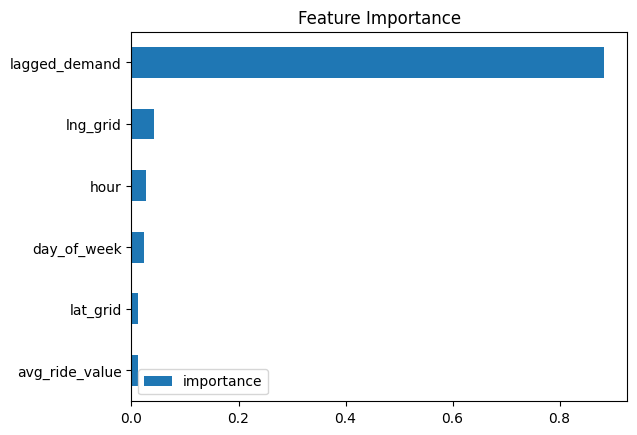

In [26]:
fi = pd.DataFrame(data = model.feature_importances_,
                 index=model.feature_names_in_,
                 columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

#### Plot Actual vs. Predicted counts of demands

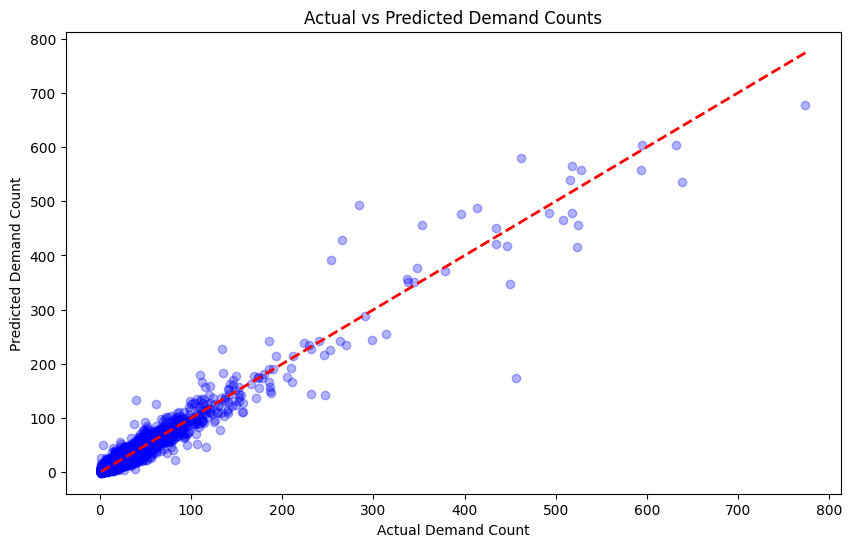

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Demand Count')
plt.ylabel('Predicted Demand Count')
plt.title('Actual vs Predicted Demand Counts')
plt.show()

#### Generate hourly predictions for each day of the week

In [28]:
def predict_demand(model, grid_df, days=range(7), hours=range(24)):
    """
    Predicts demand across all locations for each day of the week and hour of the day.

    Parameters:
        model: trained prediction model
        grid_df: dataframe containing lat/lng grid locations
        days: range of days to predict (default: 0-6 for Monday to Sunday)
        hours: range of hours to predict (default: 0-23)

    Returns:
        Dataframe with predicted demand for each location (lat/lng grid) and each day-hour combination.
    """
    predictions = []

    # Iterate over each day of the week and each hour of the day
    for day in days:
        for hour in hours:
            grid_df['day_of_week'] = day
            grid_df['hour'] = hour
            
            # Generate predictions for each location in the grid for this day-hour combination
            predicted_demand = model.predict(grid_df[features])
            
            grid_df['predicted_demand'] = predicted_demand
            grid_df['day_of_week'] = day
            grid_df['hour'] = hour
            
            predictions.append(grid_df[['lat_grid', 'lng_grid', 'hour', 'day_of_week', 'predicted_demand']].copy())

    high_demand_regions = pd.concat(predictions, ignore_index=True)
    return high_demand_regions

In [29]:
high_demand_areas = predict_demand(model, df_tallinn_aggregated[features].copy())

# Print sample of results
print(high_demand_areas.head(100))

    lat_grid  lng_grid  hour  day_of_week  predicted_demand
0      59.35      24.6     0            0          4.166127
1      59.35      24.6     0            0          2.481579
2      59.35      24.6     0            0          2.481579
3      59.35      24.6     0            0          2.481579
4      59.35      24.6     0            0          2.507114
..       ...       ...   ...          ...               ...
95     59.35      24.8     0            0          2.494680
96     59.35      24.8     0            0          2.332296
97     59.35      24.8     0            0          2.494680
98     59.35      24.8     0            0          2.494680
99     59.35      24.8     0            0          2.301337

[100 rows x 5 columns]


#### Generate predictions for a specific hour and day

In [30]:
def predict_demand_for_specific_hour_and_day(hour, day_of_week):
    df_prediction = df_tallinn_aggregated.copy()
    df_prediction['hour'] = hour
    df_prediction['day_of_week'] = day_of_week
    
    df_prediction['predicted_demand'] = model.predict(df_prediction[features])
    
    high_demand_regions = df_prediction[df_prediction['predicted_demand'] > df_prediction['predicted_demand'].quantile(0.75)]
    
    return high_demand_regions[['lat_grid', 'lng_grid', 'predicted_demand']]

In [31]:
# Example usage for hour 17 (5 PM) on a Thursday
high_demand_areas_for_specific_hour_and_day = predict_demand_for_specific_hour_and_day(hour=17, day_of_week=3)
print(high_demand_areas_for_specific_hour_and_day)

       lat_grid  lng_grid  predicted_demand
2390      59.37     24.68         17.401438
2391      59.37     24.68         17.181307
2755      59.37     24.71         20.255861
2757      59.37     24.71         19.186930
2759      59.37     24.71         17.293236
...         ...       ...               ...
27318     59.45     24.87         20.278347
27319     59.45     24.87         20.228106
29685     59.48     24.85         19.758425
29689     59.48     24.85         19.802261
29751     59.48     24.85         19.620913

[7755 rows x 3 columns]


#### Plot high-demand regions for specific day and hour

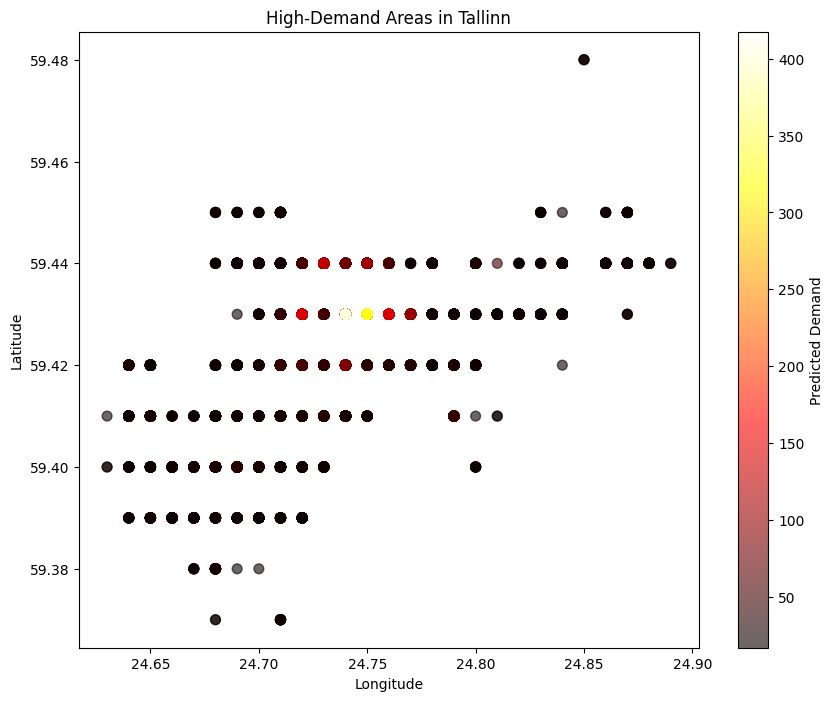

In [32]:
plt.figure(figsize=(10, 8))
plt.scatter(high_demand_areas_for_specific_hour_and_day['lng_grid'], high_demand_areas_for_specific_hour_and_day['lat_grid'],
            c=high_demand_areas_for_specific_hour_and_day['predicted_demand'], cmap='hot', s=50, alpha=0.6)
plt.colorbar(label='Predicted Demand')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("High-Demand Areas in Tallinn")
plt.show()

#### Plot high-demand regions for specific day and hour as a heatmap

In [33]:
# Center map on Tallinn
map_tallinn = folium.Map(location=[59.437, 24.7536], zoom_start=12)

high_demand_areas_for_specific_hour_and_day['scaled_demand'] = high_demand_areas_for_specific_hour_and_day['predicted_demand'] / high_demand_areas_for_specific_hour_and_day['predicted_demand'].max()
low_demand = high_demand_areas_for_specific_hour_and_day['predicted_demand'].quantile(0.2)
medium_low_demand = high_demand_areas_for_specific_hour_and_day['predicted_demand'].quantile(0.4)
medium_high_demand = high_demand_areas_for_specific_hour_and_day['predicted_demand'].quantile(0.6)
high_demand = high_demand_areas_for_specific_hour_and_day['predicted_demand'].quantile(0.8)

heat_data = [
    [row['lat_grid'], row['lng_grid'], row['scaled_demand']] 
    for _, row in high_demand_areas_for_specific_hour_and_day.iterrows()
]

HeatMap(
    heat_data, 
    radius=15,
    max_zoom=13,
    blur=12,
    min_opacity=0.4,
    gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'yellow', 1: 'red'}
).add_to(map_tallinn)

# Add a custom legend as an HTML template, including demand ranges
legend_html = f'''
     <div style="
     position: fixed; 
     bottom: 50px; left: 50px; width: 180px; height: 190px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white;
     padding: 10px;
     ">
     <strong>Demand Intensity (Counts)</strong> <br>
     <i style="background:blue; width: 18px; height: 18px; display: inline-block;"></i>&nbsp; Low ({0} - {int(low_demand)})<br>
     <i style="background:lime; width: 18px; height: 18px; display: inline-block;"></i>&nbsp; Medium-Low ({int(low_demand)} - {int(medium_low_demand)})<br>
     <i style="background:yellow; width: 18px; height: 18px; display: inline-block;"></i>&nbsp; Medium-High ({int(medium_low_demand)} - {int(medium_high_demand)})<br>
     <i style="background:red; width: 18px; height: 18px; display: inline-block;"></i>&nbsp; High ({int(medium_high_demand)} - {int(high_demand)})<br>
     </div>
     '''

# Add legend to the map
map_tallinn.get_root().html.add_child(folium.Element(legend_html))

# Save and display map
map_tallinn.save("tallinn_high_demand_map_with_range_legend.html")
map_tallinn